In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import cm
import arviz as az
import pymc3 as pm
import joblib

# Assignment 1: Toxicity bioassay

By Dyuman Bulloni and Davide Gamba

## 1. Problem and data

A **bioassay** is biochemical test to estimate the potency of a sample compound. A typical bioassay involves a stimulus (ex. drugs) applied to a subject (ex. animals, tissues, plants). The corresponding response (ex. death) of the subject is thereby triggered and measured (Wikipedia).

The following bioassay taken from Racine et al. (1986) is meant to evaluate the toxicity of a drug on animals. The effect of the drug is evaluated at $N=4$ dose levels. Each dose level $x_i$ is administered to a batch of $n_i$ animals. The number of deaths $y_i$ is the observed response.

| |Dose $x_i$ (log g/ml) | Number of animals $n_i$ | Number of deaths $y_i$ |
| ---|--- | --- | --- |
| 1|-0.86 | 5 | 0 |
| 2|-0.30 | 5 | 1 |
| 3|-0.05 | 5 | 3 |
| 4|0.73  | 5 | 5 |


For instance, the dose level $x_3=-0.05$ has been administered at $n_3=5$ animals. Out of the 5 animals, $y_3=3$ died. <br/>
Note that the dose $x_i$ is measured on a logarithmic scale. Thus, negative concentration levels are present.

We define for convenience (both as math symbols and as Python objects) the vectors $x$, $n$, and $y$ containing the quantities of the corresponding columns.

In [8]:
x = np.array([-0.86, -0.30, -0.05, 0.73]) # dose levels
n = np.array([5., 5., 5., 5.]) # number of subjects per dose level
y = np.array([0, 1, 3, 5]) # number of deaths per dose level

## Modeling assumptions

For the probabilistic model, we make the following assumptions:

1. The outcome of the $n_i$ animals within each group $i$ are *independent*. Each animal in the group has probability $p_i$ of death.

2. The probability of death $p_i$ depends on the dose $x_i$ as follows:
    $$p_i = \rm{sigm}(\alpha + \beta x_i),$$ 
    where 
    \begin{align*}
    \rm{sigm}(z) = \frac{1}{1 + e^{-z}}.
    \end{align*}
3. The prior probability of the parameters 
$\theta = \begin{bmatrix}
\alpha \\
\beta
\end{bmatrix}$
is Gaussian: 
\begin{align}
\alpha &\sim \mathcal{N}(\mu_\alpha, \sigma^2_\alpha), \qquad \mu_\alpha = 0, \sigma_\alpha=2\\
\beta &\sim \mathcal{N}(\mu_\beta, \sigma^2_\beta), \qquad \mu_\beta=10, \sigma_\beta=10.
\end{align}
4. The outcomes in the four groups are independent of each other, given $\theta$.


## 1.1: Probabilistic model

* Derive and comment the full probabilistic model.

$p_i$ is the probability of death for group i, given by:

$p_i = sigm(\alpha + \beta\cdot x_i) = 1 / (1 + e^(-(\alpha + \beta \cdot x_i)))$

$y_i$ is the number of deaths observed in group i, and $n_i$ is the number of animals in group i.

The prior distributions for the parameters $\alpha$ and $\beta$ are given as:


p($\alpha$) = $N(\mu_\alpha, \sigma_\alpha^2)$

p($\beta$) = $N(\mu_\beta, \sigma_\beta^2)$


where N($\mu, \sigma^2$) represents the normal distribution with mean $\mu$ and variance $\sigma^2$.
The values for the mean and standard deviation of these distributions were specified in the previous information as
$\mu_\alpha = 0, \sigma_\alpha = 2, \mu_\beta = 10$, and $\sigma_\beta = 10$.

The full probabilistic model is then given by the product of the likelihood function and the prior distributions:

$p(y, \theta | x, n) = p(y | x, n, \theta) \cdot p(\alpha) \cdot p(\beta)$

This equation represents the joint probability of the observed data, y, and the parameters, theta, given the dose levels, x, and the number of animals, n.

## 1.2: Maximum Likelihood estimation 

* Derive an analytical expression of the likelihood function $\mathcal{L}(\theta) = P(y|\theta)$.

The likelihood function for this model is given by:

$\mathcal{L}(\theta) = ∏_{i=1}^N (p_i)^{y_i} \cdot (1 - p_i)^{n_i - y_i}$

* Write a Python function corresponding to the likelihood function $\mathcal{L}(\theta)$. Ignore multiplicative factors which do not depend on $\theta$.

In [3]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def lik(alpha, beta):
    prob = 1
    for idx in range(len(x)):
        p_i = sigmoid(alpha+beta*x[idx])
        prob *= (p_i**y[idx])*((1-p_i)**(n[idx]-y[idx]))
    return prob

* Visualize the likelihood function in 2D and comment the obtained figure. 

   Hints:
    * you may use the `pcolormesh` function of `matplotlib`
    * appropriate ranges for $\alpha$ and $\beta$ are $[-4, 8]$ and $[-10, 40]$, respectively
    * an appropriate step size for both $\alpha$ and $\beta$ is 0.01

In [7]:
precision = 0.01
alpha_candidates = np.arange(-4,8,precision)
beta_candidates = np.arange(-10,40,precision)
def test_canditates(lik_function):
    lik_values = np.zeros(shape=(len(alpha_candidates), len(beta_candidates)))
    for adx in range(len(alpha_candidates)):
        for bdx in range(len(beta_candidates)):
            lik_values[adx, bdx] = lik_function(alpha_candidates[adx], beta_candidates[bdx])
    return lik_values

In [ ]:
lik_values = test_canditates(lik)
joblib.dump(lik_values, 'data/lik_values.pkl')

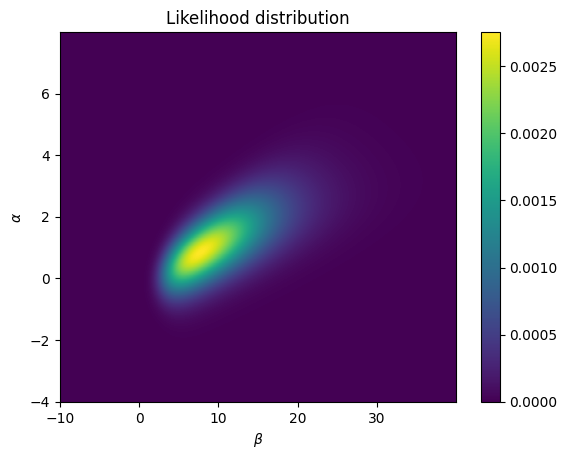

In [49]:
lik_values = joblib.load('data/lik_values.pkl')
plt.pcolormesh(beta_candidates, alpha_candidates,lik_values)
plt.colorbar()
plt.title(f"Likelihood distribution")
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\alpha$")
plt.show()

* Derive an analytical expression of the log-likelihood function $\ell(\theta)$. 

$\ln(\mathcal{L}(\theta)) = \ln(∏_{i=1}^N (p_i)^{y_i} \cdot (1 - p_i)^{n_i - y_i})$

$\ln(\mathcal{L}(\theta)) = \sum_{i=1}^N \ln((p_i)^{y_i} \cdot (1 - p_i)^{n_i - y_i})$

$\ln(\mathcal{L}(\theta)) = \sum_{i=1}^N (y_i \log(p_i) + (n_i - y_i) \ln(1 - p_i))$

$\ln(\mathcal{L}(\theta)) = \sum_{i=1}^N y_i \cdot ln(p_i) + (n_i - y_i) \cdot ln(1 - p_i)$

so

$\ell(\theta) = \sum_{i=1}^N (y_i \cdot \ln(p_i) + (n_i - y_i) \cdot \ln(1 - p_i))$


* Write a Python function corresponding to the log-likelihood function $\ell(\theta)$, possibly up to an additive factor not depending on $\theta$. 


In [101]:
def log_lik(alpha, beta):
    prob = 1
    for idx in range(len(x)):
        p_i = sigmoid(alpha+beta*x[idx])
        if p_i == 0:
            p_i += 1e-7
        elif p_i == 1:
            p_i -= 1e-7
        prob += (y[idx]*np.log(p_i)+(n[idx]-y[idx])*np.log(1-p_i))
    return prob

In [ ]:
log_lik_values = test_canditates(log_lik)
joblib.dump(log_lik_values,'data/log_lik_values.pkl')

* Visualize the log-likelihood function in 2D and comment the obtained figure.

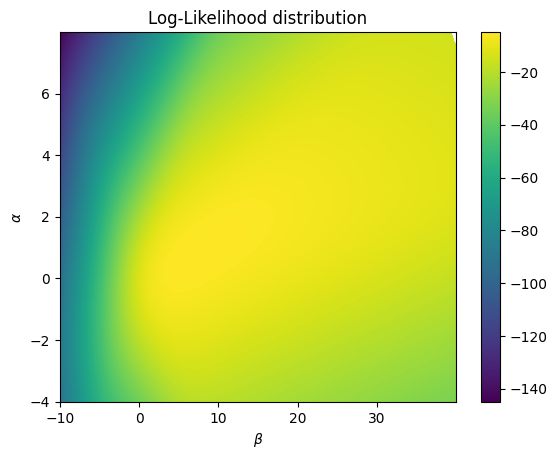

In [54]:
log_lik_values = joblib.load("data/log_lik_values.pkl")

plt.pcolormesh(beta_candidates, alpha_candidates,log_lik_values)
plt.colorbar()
plt.title(f"Log-Likelihood distribution")
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\alpha$")
plt.show()

The image is not really readable, but this is due the short range between values.
We can adjust and see the zone of interest by setting a vmin.

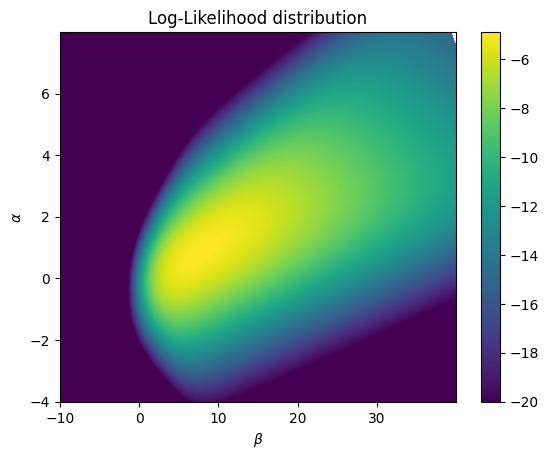

In [57]:
lik_values = joblib.load('data/lik_values.pkl')
plt.pcolormesh(beta_candidates, alpha_candidates,log_lik_values, vmin=-20)
plt.colorbar()
plt.title(f"Log-Likelihood distribution")
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\alpha$")
plt.show()


We can see that we obtained a wider distribution, compared to the non-log likelihood, in which the maximum likelihood seems to lie at about beta = 7 and alpha = 0.1

In [20]:
joblib.dump(lik_values,'data/lik_values.pkl')
joblib.dump(log_lik_values,'data/log_lik_values.pkl')

['data/log_lik_values.pkl']

* Compute the maximum likelihood estimate $\alpha^{\rm ml}, \beta^{\rm ml}$ of the parameters $\alpha, \beta$ through numerical optimizations. 

    Hints:
     * You may use the Python function `scipy.optimize.minimize`. 
     * You may look at the figures above to define a good starting point for optimization 
     * You may either minimize the likelihood or the log-likelihood. What is your choice?

To find the maximum likelihood estimate, we can minimize the negative likelihood function.

A good position as starting point are the correspective means, 0 for $\alpha$ and 10 for $\beta$.
It is better to minimize in respect to the log-likelihood, since it is guaranteed to be convex and optimize to a global minimum.
For the sake of the exercise, we would test it both and check that the result it is in fact the same.

In [59]:
import scipy
theta = [alpha_candidates, beta_candidates]
def neg_lik(theta):
    return -lik(theta[0], theta[1])

result = scipy.optimize.minimize(fun=neg_lik,x0=[0,10])
alpha_ml, beta_ml = result.x
print(f"the maximum likelihood estimate alpha is {alpha_ml}, where the maximum likelihood estimate beta is {beta_ml},")
pos = [alpha_ml,beta_ml]

the maximum likelihood estimate alpha is 0.8459193007965629, where the maximum likelihood estimate beta is 7.743471926362306,


* Visualize the likelihood function in 2D together with the ML estimate. Comment the obtained figure. 

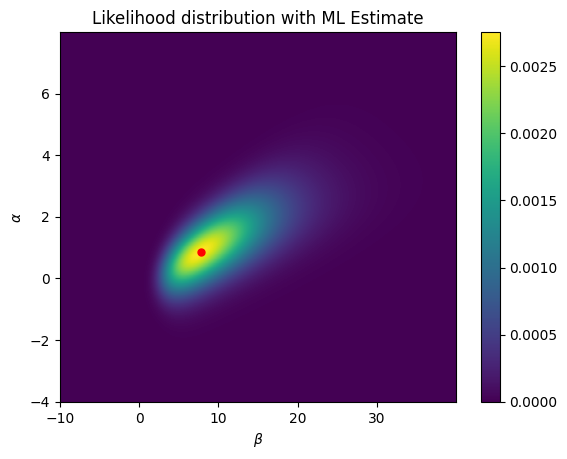

In [60]:
plt.pcolormesh(beta_candidates, alpha_candidates, lik_values)
plt.plot(pos[1],pos[0],color="red", marker='.',markersize=10)
plt.colorbar()
plt.title(f"Likelihood distribution with ML Estimate")
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\alpha$")
plt.show()

In [61]:
def neg_log_lik(theta):
    return -log_lik(theta[0], theta[1])

result_log = scipy.optimize.minimize(fun=neg_log_lik,x0=[0,10])
alpha_log_ml, beta_log_ml = result.x
print(f"the maximum likelihood estimate alpha is {alpha_log_ml}, where the \n"
      f"maximum likelihood estimate beta is {beta_log_ml},")
pos_log = [alpha_log_ml, beta_log_ml]

the maximum likelihood estimate alpha is 0.8459193007965629, where the 
maximum likelihood estimate beta is 7.743471926362306,


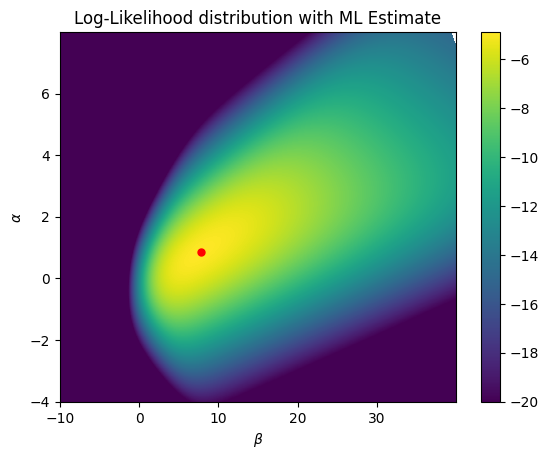

In [62]:
plt.pcolormesh(beta_candidates, alpha_candidates, log_lik_values, vmin=-20)
plt.plot(pos_log[1],pos_log[0],color="red", marker='.',markersize=10)
plt.colorbar()
plt.title(f"Log-Likelihood distribution with ML Estimate")
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\alpha$")
plt.show()


As expected, the maximum likelihood point resides at the center of the largest values of both likelihoods, meaning that the maximization worked.

## 1.2: Maximum A Posteriori estimation

* Derive an analytical expression of the posterior $f(\theta | y)$, up to a multiplicative factor not depending on $\theta$. 

Hint: exploit the already-obtained likelihood and the known functional form of the Gaussian pdf.


Given that the likelihood function is
$\mathcal{L}(\theta) = ∏_{i=1}^N (p_i)^{y_i} \cdot (1 - p_i)^{n_i - y_i}$,
and the prior is a Gaussian distribution with mean
$\mu$ and variance $\sigma^2$,

$f(\theta|\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(\theta-\mu)^2}{2\sigma^2}}$

By the Bayes' theorem, we know that:

$f(\theta|y) = \frac{p(y|\theta)f(\theta)}{f(y)}$

given $\mathcal{L}(\theta) = P(y|\theta)$

 we can substitute into:

$f(\theta|y) = \frac{\mathcal{L}(\theta)f(\theta)}{f(y)}$
$f(\theta|y) = \frac{\left(\prod_{i=1}^N (p_i)^{y_i} \cdot (1 - p_i)^{n_i - y_i}\right)
\left(\frac{1}{\sqrt{2\pi\sigma^2}}\cdot e^{-\frac{(\theta-\mu)^2}{2\sigma^2}}\right)}{f(y)}$

We can see that this expression of the posterior depends on the data $y$ and the unknown constant $f(y)$,
 which doesn't depend on $\theta$. So, the analytical expression of the posterior is

$f(\theta|y) \propto \left(\prod_{i=1}^N (p_i)^{y_i} \cdot (1 - p_i)^{n_i - y_i}\right)
\left(\frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{-\frac{(\theta-\mu)^2}{2\sigma^2}}\right)$

up to a multiplicative factor not depending on $\theta$, that we can ignore in the unnormalized version.

* Derive an analytical expression of the log-posterior $\log f(\theta | y)$, up to an additive factor not depending on $\theta$.

Given the posterior:

$f(\theta|y) \propto \left(\prod_{i=1}^N (p_i)^{y_i} \cdot (1 - p_i)^{n_i - y_i}\right)
\left(\frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{-\frac{(\theta-\mu)^2}{2\sigma^2}}\right)$

Taking the natural logarithm of the posterior:

$\ln(f(\theta|y)) \propto \ln\left(\prod_{i=1}^N (p_i)^{y_i} \cdot
(1 - p_i)^{n_i - y_i}\right) + \ln\left(\frac{1}{\sqrt{2\pi\sigma^2}} \cdot
e^{-\frac{(\theta-\mu)^2}{2\sigma^2}}\right)$

$\ln(f(\theta|y)) \propto \sum_{i=1}^N (y_i \ln(p_i) + (n_i - y_i) \ln(1 - p_i)) -
\frac{1}{2}\ln(2\pi\sigma^2) - \frac{(\theta-\mu)^2}{2\sigma^2}$

$\ln(f(\theta|y)) \propto \sum_{i=1}^N (y_i \ln(p_i) + (n_i - y_i) \ln(1 - p_i)) - \frac{1}{2}\ln(2\pi\sigma^2) - \frac{(\theta-\mu)^2}{2\sigma^2} + C$

where C is a constant that doesn't depend on $\theta$.

* Write the unnormalized posterior and log-posterior (up to a multiplicative/additive factor, respectively) as Python functions.

In [74]:
import scipy.stats as stats
def prior_alpha(alpha):
    return stats.norm.pdf(alpha, loc=0, scale=2)
def prior_beta(beta):
    return stats.norm.pdf(beta, loc=10, scale=10)

def unnormalized_posterior(alpha, beta):
    lik(alpha, beta) * prior_alpha(alpha) * prior_beta(beta)

def log_posterior(alpha, beta):
    return log_lik(alpha, beta) + np.log(prior_alpha(alpha)) + np.log(prior_beta(beta))

def neg_log_posterior(theta):
    return - log_posterior(theta[0], theta[1])

In [80]:
log_posterior(0,10)

-10.951228016481883

* Compute the maximum a posteriore estimate $\alpha^{\rm MAP}, \beta^{\rm MAP}$.

In [64]:
post_result_log = scipy.optimize.minimize(fun=neg_log_posterior,x0=[0,10])
post_alpha_map, post_beta_map = post_result_log.x
print(f"the posterior estimate alpha is {post_alpha_map}, where the \nposterior estimate beta is {post_beta_map},")



the posterior estimate alpha is 0.7392234802847939, where the 
posterior estimate beta is 7.660158117316576,


* Visualize the MAP estimate together with the unnormalized posterior in 2D. Comment the results.

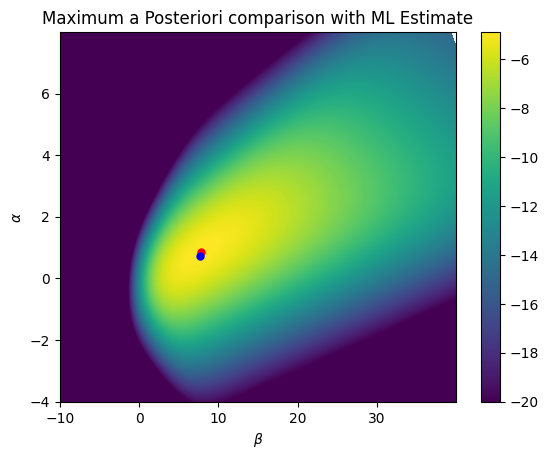

In [65]:
plt.pcolormesh(beta_candidates, alpha_candidates, log_lik_values, vmin=-20)
plt.plot(pos[1],pos[0],color="red", marker='.',markersize=10)
plt.plot(post_beta_map, post_alpha_map,color="blue", marker='.',markersize=10)
plt.title(f"Maximum a Posteriori comparison with ML Estimate")
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\alpha$")
plt.colorbar()

plt.show()

We can see that the two posterior estimations appear to be very similar, but not exactly equal. 
Nevertheless, the value is more than valid. 

## 1.3 Brute-force posterior estimation

* Compute a gridding approximation of the *normalized* posterior, with the correct normalization constant. Explain the passages.

the posterior distribution $p_{\rm post}(\theta)$ is:
$f_{\rm post}(\theta) = f(\theta | y) = \frac{\overbrace{P(y|\theta)}^{=\mathcal{L}(\theta)} \cdot f_{\rm prior}(\theta)}{P(y)},$
where $P(y) = \int{P(y|\theta)\; d\theta}$.

$f_{\rm post}(\theta) = \frac{1}{Z} \cdot \mathcal{L}(\theta) f_{\rm prior}(\theta),$

where the normalization constant $Z$ must be chosen to satisfy:

$\int_\theta f_{\rm post}(\theta) \; d\theta = 1,$
thus

$Z = \int_\theta \mathcal{L}(\theta) f_{\rm prior}(\theta) \; d\theta = 1.$

Riemann sum on a uniform grid, with step size $\Delta \theta$
$Z \approx \Delta \theta \sum_{i} \mathcal{L}(\theta_i) f_{\rm prior}(\theta_i)$

Therefore the procedure is the same as the unnormalized, just dividing by $Z$

In [86]:
posterior_grid = np.zeros(shape=(len(alpha_candidates), len(beta_candidates)))
for adx in range(len(alpha_candidates)):
    for bdx in range(len(beta_candidates)):
        posterior_grid[adx, bdx] = log_posterior(alpha_candidates[adx], beta_candidates[bdx])
posterior_grid = posterior_grid / np.nansum(posterior_grid)

C:\Users\dyuma\AppData\Local\Temp\ipykernel_18448\46726876.py:5: RuntimeWarning: divide by zero encountered in log
  prob += (y[idx]*np.log(p_i)+(n[idx]-y[idx])*np.log(1-p_i))
C:\Users\dyuma\AppData\Local\Temp\ipykernel_18448\46726876.py:5: RuntimeWarning: invalid value encountered in double_scalars
  prob += (y[idx]*np.log(p_i)+(n[idx]-y[idx])*np.log(1-p_i))


In [87]:
joblib.dump(posterior_grid, 'data/log_posterior.pkl')


['data/log_posterior.pkl']

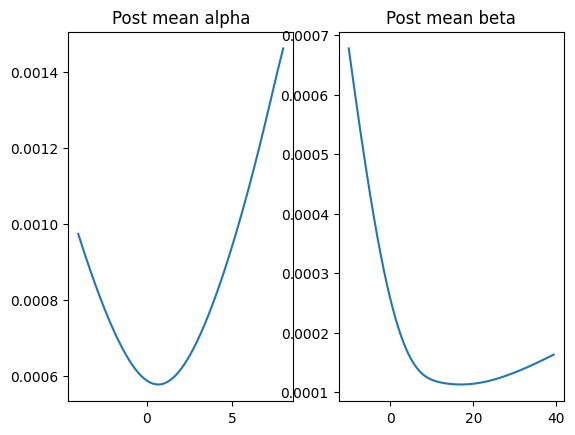

In [88]:
posterior_grid= joblib.load('data/log_posterior.pkl')

#posterior marginal of alpha
plt.subplot(1, 2, 1)
post_alpha_gridding = np.nansum(posterior_grid, axis=1)
plt.plot(alpha_candidates,post_alpha_gridding)
plt.title("Post mean alpha")

#posterior marginal of beta
post_beta_gridding = np.sum(posterior_grid, axis=0)
plt.subplot(1, 2, 2)
plt.plot(beta_candidates,post_beta_gridding)
plt.title("Post mean beta")

plt.show()

* Using the grid-based approximation of the posterior, compute the posterior mean of $\alpha$ and $\beta$.

In [93]:
posterior_grid= joblib.load('data/log_posterior.pkl')
mean_alpha_gridding = np.nansum(alpha_candidates * post_alpha_gridding)
mean_beta_gridding = np.nansum(beta_candidates * post_beta_gridding)

print(f"the posterior estimate alpha is {mean_alpha_gridding:.3f}, where the \n"
      f"posterior estimate beta is {mean_beta_gridding:.3f},")

the posterior estimate alpha is 2.645, where the 
posterior estimate beta is 7.724,


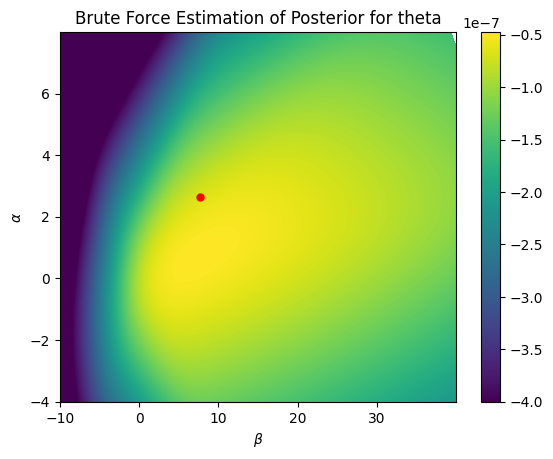

In [98]:
plt.pcolormesh(beta_candidates, alpha_candidates, -posterior_grid, vmin=-4e-7)
plt.plot(mean_beta_gridding,mean_alpha_gridding,color="red", marker='.',markersize=10)
plt.title(f"Brute Force Estimation of Posterior for theta")
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\alpha$")
plt.colorbar()

plt.show()

Using the brute-force method, it seems the result is slightly different and it is not anymore centered in the higher values but on their borders.

## 1.4 Monte-carlo posterior estimation

* Obtain a sample-based approximation of the posterior $f(\theta | y)$ by implementing the Metropolis algorithm from scratch.

In [150]:
def f_ratio_fun(theta_propose, theta_current):
    log_f_propose = log_posterior(theta_propose[0],theta_propose[1])
    log_f_current = log_posterior(theta_current[0],theta_current[1])
    log_f_ratio = log_f_propose - log_f_current # log(p_prop/p_prev) = log(p_prop) - log(p_prev)
    f_ratio = np.exp(log_f_ratio)
    #f_ratio = np.nan_to_num(p_ratio, nan=0.0)
    return f_ratio

sigma_alpha = 2 # prior standard deviation
sigma_beta = 10
# Initialize the chain with a starting point
alpha_current = 0
beta_current = 10
N = 100_000 # chain length

In [151]:
alpha_step = alpha_current
beta_step = beta_current
thetas = [] # here we collect the theta values from the chain
metropolis_samples = np.full(shape=(alpha_candidates.shape[0], beta_candidates.shape[0]),fill_value=-1000)

for idx in range(N):

    alpha_prop = alpha_step + sigma_alpha*np.random.randn()
    beta_prop = beta_step + sigma_beta*np.random.randn()

    f_ratio = f_ratio_fun((alpha_prop,beta_prop), (alpha_step,beta_step))
    accept_prob = np.minimum(1.0, f_ratio)
    accept = (np.random.rand() < accept_prob)

    if accept:
        alpha_step = alpha_prop
        beta_step = beta_prop
        thetas.append((alpha_step, beta_step))

        metropolis_samples[int(round(alpha_step-alpha_candidates[0]*100)),
                               int(round(beta_step -beta_candidates[0])*100)] = log_posterior(alpha_step, beta_step)

* Compare the Metropolis samples with the gridding-based approximation of the posterior distribution $f(\theta | y)$ and comment the result.

In [152]:
(metropolis_samples != -1000).sum()

177

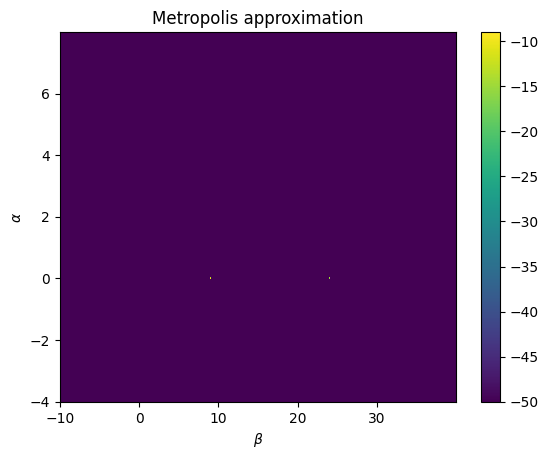

In [153]:
plt.pcolormesh(beta_candidates, alpha_candidates, metropolis_samples, vmin=-50)
plt.title("Metropolis approximation")
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\alpha$")
plt.colorbar()
plt.show()

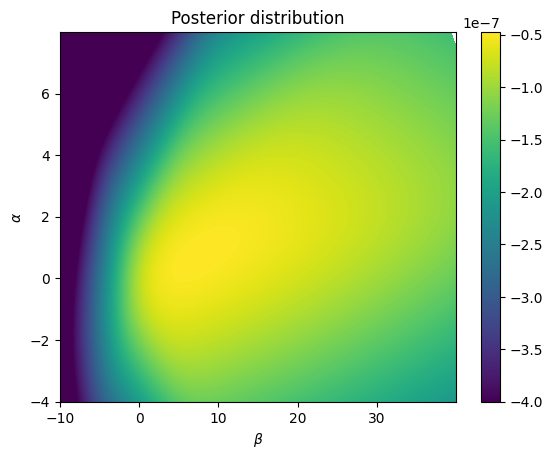

In [131]:
plt.pcolormesh(beta_candidates, alpha_candidates, -posterior_grid, vmin=-4e-7)
plt.title(f"Posterior distribution")
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\alpha$")
plt.colorbar()
plt.show()

Metropolis is not filled properly, but the relevant pixels are coherent with the previous values. 


* Obtain a sample-based approximation of the posterior $f(\theta | y)$ using pymc3.

In [107]:
import pymc3 as pm
import numpy as np

# Specify the model
with pm.Model() as model:
    # Define the prior for alpha and beta
    alpha = pm.Normal('alpha', mu=0, sigma=2)
    beta = pm.Normal('beta', mu=10, sigma=10)

    p_deaths = pm.Deterministic('p_deaths', sigmoid(alpha + beta * x))
    y_obs = pm.Binomial('y_obs', p=p_deaths, n=n, observed=y)

    # Perform inference
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\users\dyuma\scuola\d3a\bayes\venv\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\users\dyuma\scuola\d3a\bayes\venv\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
The acceptance probability does not match the target. It is 0.8948164530502518, but should be close to 0.8. Try to increase the number of tuning steps.


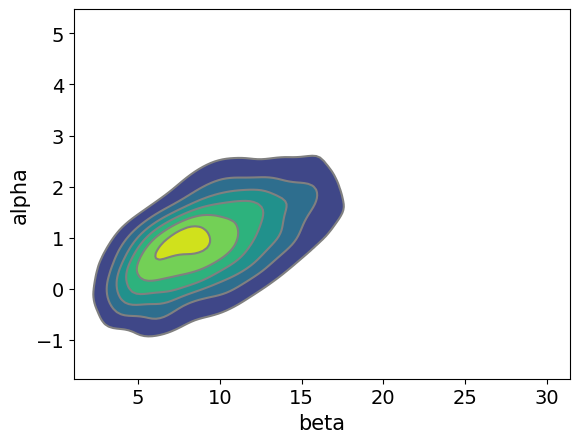

In [108]:
with model:
    az.plot_pair(trace,
                 kind="kde",
                 var_names=['beta','alpha']);

In [109]:
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha        0.930  0.867  -0.646    2.605      0.022    0.016    1568.0   
beta         9.747  4.093   3.072   17.459      0.118    0.083    1223.0   
p_deaths[0]  0.009  0.027   0.000    0.037      0.001    0.000    1406.0   
p_deaths[1]  0.160  0.118   0.002    0.373      0.002    0.002    2603.0   
p_deaths[2]  0.596  0.167   0.292    0.898      0.004    0.003    1853.0   
p_deaths[3]  0.991  0.028   0.960    1.000      0.001    0.000    1150.0   

             ess_tail  r_hat  
alpha          1471.0    1.0  
beta           2052.0    1.0  
p_deaths[0]    1980.0    1.0  
p_deaths[1]    2316.0    1.0  
p_deaths[2]    1827.0    1.0  
p_deaths[3]    1789.0    1.0

* Comment the results obtained with pymc3 and compare them with previous results (gridding and Metropolis from scratch).

The results from pymc3 seem coherent with all the values found and are likely the most robust,
as $r_{hat}$ is equal to 1 and therefore the model is converging.